Non-Linear Curve Fitting, Part 1
=========================

<div class="overview-this-is-a-title overview">
<p class="overview-title">Overview</p>
<p>Questions</p>
    <ul>
        <li>How can I analyze enzyme kinetics data in Python?</li>
        <li>What is the process for non-linear least squares curve fitting in Python?</li>
    </ul>
<p>Objectives:</p>
    <ul>
        <li> Create a pandas dataframe with enzyme kinetics data from a .csv file</li>
        <li> Add velocity calculations to the dataframe</li>
        <li> Perform the non-linear regression calculations</li>
    </ul>
    
<p>In this module, we will calculate initial rates from the raw data (&Delta;A<sub>405</sub>) in an enzyme kinetics experiment with alkaline phosphatase. In the process, we will import the raw data into a pandas dataframe, use some pandas tools to reorganize the data, produce a second pandas dataframe that contains the substrate concentrations and initial rates at each concentration. Finally, we will export this information to a csv file to use in the next module, where you will explore nonlinear curve fitting in python.
    </p>
</div>

### Navigating the command line
We start by importing data from a csv file as we did earlier with the data for linear regression. These data represent the rate of p-nitrophenol appearance for a series of p-nitrophenol phosphate concentrations in the presence of alkaline phosphatase. We will import the libraries we need, import the data and set up a pandas dataframe.

In [1]:
# import the libraries we need
import os # to create a filehandle for the .csv file
import pandas as pd # for importing the .csv file and creating a dataframe
from scipy import stats # for performing non-linear regression

In [2]:
pwd  ## make sure we are in '/Users/username/Desktop/python-scripting-biochemistry'

'/Users/pac8612/Desktop/python-scripting-biochemistry/biochemist-python/chapters'

Use the `cd` command to get to the correct directory. The simplest way is to use `~` to indicate the root directory followed by `Desktop/python-scripting-biochemistry`.

In [3]:
cd ~/Desktop/python-scripting-biochemistry

/Users/pac8612/Desktop/python-scripting-biochemistry


Your output here will be different. It's important to move to the correct directory level. You may need to move up or down the directory tree. Once you are in the correct directory, it is time to use the `os.path.join` from the `os` library to create a filehandle that works in any operating system. You can confirm that the path is correct if you print the filehandle.

In [8]:
# You can create the filehandle once you are in the right directory
datafile = os.path.join('biochemist-python', 'chapters', 'data', 'AP_kinetics.csv') # filehandle created
print(datafile)  # filehandle confirmed

biochemist-python/chapters/data/AP_kinetics.csv


### Creating the pandas dataframe
The filehandle, `datafile`, points to a csv file that contains the raw kinetics data. As we saw in the `Working with Pandas` module, the pandas library has a tool for creating a dataframe from an existing csv file. Notice that the variable for the dataframe is called AP_kinetics_df. The `_df` at the end of the variable name is a reminder that this is a pandas dataframe.

In [9]:
# Creating the pandas dataframe using read_csv
AP_kinetics_df = pd.read_csv(datafile)
AP_kinetics_df.head()  # looking at the first five rows of the dataframe 

,pNPP (mM),0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,...,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5
0,20.0,0.127118,0.269802,0.373572,0.518850,0.616135,0.762710,0.917068,1.037700,1.214109,...,1.498180,1.556550,1.601950,1.834135,1.945688,2.137663,2.116909,2.381522,2.464538,2.490481
1,10.0,0.121434,0.257587,0.364301,0.500455,0.613302,0.743322,0.841451,0.981283,1.137062,...,1.295294,1.413048,1.658369,1.785936,1.821507,2.060695,2.064375,2.296203,2.307243,2.575869
2,7.0,0.123059,0.239086,0.369177,0.468796,0.556695,0.724289,0.795781,0.946967,1.086434,...,1.289188,1.392323,1.599765,1.624377,1.810723,1.818927,1.952534,2.172868,2.137708,2.437737
3,4.0,0.103351,0.210920,0.313216,0.400747,0.500934,0.620103,0.752983,0.826805,0.920664,...,1.206460,1.328793,1.439526,1.505966,1.660991,1.653609,1.739032,1.860310,1.983698,2.003736
4,2.0,0.088046,0.177801,0.246186,0.352183,0.444503,0.538533,0.586402,0.711205,0.753946,...,0.893280,1.036034,1.111258,1.172804,1.282220,1.436087,1.511311,1.523278,1.624146,1.692531


When you look at the head of the dataframe, notice that the index (the item at the far left of each row) is an integer. In this case, we want to use the pNPP (mM) values as the index that are found in the first series as the index. There is a simple fix - the set_index function. 

```python
AP_kinetics_df.set_index("pNPP (mM)", inplace=True)
```

By making the pNPP concentrations the index for each row, we can easily omit them from our initial rate calculations. We use the `inplace=True` option to make the change to the dataframe permanent.

In [10]:
AP_kinetics_df.set_index("pNPP (mM)", inplace=True)
AP_kinetics_df.head()

,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5
pNPP (mM),,,,,,,,,,,,,,,,,,,,
20.0,0.127118,0.269802,0.373572,0.518850,0.616135,0.762710,0.917068,1.037700,1.214109,1.323068,1.498180,1.556550,1.601950,1.834135,1.945688,2.137663,2.116909,2.381522,2.464538,2.490481
10.0,0.121434,0.257587,0.364301,0.500455,0.613302,0.743322,0.841451,0.981283,1.137062,1.238870,1.295294,1.413048,1.658369,1.785936,1.821507,2.060695,2.064375,2.296203,2.307243,2.575869
7.0,0.123059,0.239086,0.369177,0.468796,0.556695,0.724289,0.795781,0.946967,1.086434,1.113390,1.289188,1.392323,1.599765,1.624377,1.810723,1.818927,1.952534,2.172868,2.137708,2.437737
4.0,0.103351,0.210920,0.313216,0.400747,0.500934,0.620103,0.752983,0.826805,0.920664,1.001868,1.206460,1.328793,1.439526,1.505966,1.660991,1.653609,1.739032,1.860310,1.983698,2.003736
2.0,0.088046,0.177801,0.246186,0.352183,0.444503,0.538533,0.586402,0.711205,0.753946,0.880458,0.893280,1.036034,1.111258,1.172804,1.282220,1.436087,1.511311,1.523278,1.624146,1.692531


### Datatype
To simplify the analysis below, we will need to do a bit of data processing. Right now the column headers are the time values and the indexes (row labels) are the substrate concentrations. We are going to transpose the dataframe so that the column headers are the concentrations and the indexes are the time values.

Before doing that, we need to check for the datatypes on the numbers. We must ensure that the numbers are floats, rather than strings, so we can do calculations on them.

Notice that the df.dtypes command gives the overall datatype for the dataframe as an `object`, but also lists the datatypes for each of the columns.

In [11]:
AP_kinetics_df.dtypes # checking to see if the numbers are strings or floats

0.25    float64
0.5     float64
0.75    float64
1       float64
1.25    float64
1.5     float64
1.75    float64
2       float64
2.25    float64
2.5     float64
2.75    float64
3       float64
3.25    float64
3.5     float64
3.75    float64
4       float64
4.25    float64
4.5     float64
4.75    float64
5       float64
dtype: object

### Calculating initial velocities

The first column in our dataframe is the pNPP concentration in mM ('pNPP (mM)'). The other column headers are the times in minutes for the kinetic data. To simplify the calculation in the dataframe, we want to transpose these values, so that the index values (row labels) are time in minutes and the column labels are substrate concentration. We can call the transpose function from the pandas library as the letter `T`. 

```python
df_transpose = df.T
```
where `df` refers to the original dataframe and `df_transpose` is the transpose of the original dataframe. Let's see how this works with our data.

In [12]:
# Transpose to get columns as rows
AP_kinetics_df_transpose = AP_kinetics_df.T
AP_kinetics_df_transpose.head()

pNPP (mM),20.00,10.00,7.00,4.00,2.00,1.00,0.70,0.40,0.20,0.10,0.05
0.25,0.127118,0.121434,0.123059,0.103351,0.088046,0.062613,0.051681,0.034661,0.019578,0.020353,0.005635
0.5,0.269802,0.257587,0.239086,0.210920,0.177801,0.122747,0.104366,0.068643,0.040318,0.040318,0.011162
0.75,0.373572,0.364301,0.369177,0.313216,0.246186,0.193419,0.147517,0.099906,0.059896,0.056988,0.016580
1,0.518850,0.500455,0.468796,0.400747,0.352183,0.257892,0.194682,0.134567,0.073658,0.075985,0.022757
1.25,0.616135,0.613302,0.556695,0.500934,0.444503,0.309966,0.258405,0.173306,0.099827,0.100796,0.027092


Once a transpose is complete, it is always a good idea to look at the head and tail of the dataframe to make sure it worked.

In [13]:
AP_kinetics_df_transpose.tail()

pNPP (mM),20.00,10.00,7.00,4.00,2.00,1.00,0.70,0.40,0.20,0.10,0.05
4,2.137663,2.060695,1.818927,1.653609,1.436087,0.942297,0.818869,0.554578,0.313242,0.307039,0.089294
4.25,2.116909,2.064375,1.952534,1.739032,1.511311,1.053885,0.835929,0.566131,0.319639,0.342706,0.096717
4.5,2.381522,2.296203,2.172868,1.860310,1.523278,1.082402,0.921227,0.611667,0.334952,0.331463,0.102406
4.75,2.464538,2.307243,2.137708,1.983698,1.624146,1.213208,0.972407,0.613366,0.353561,0.383024,0.101918
5,2.490481,2.575869,2.437737,2.003736,1.692531,1.227466,1.003516,0.706815,0.399306,0.387676,0.113784


### Calculating the initial velocity
After transposing the dataframe, the index for each row is the time, which will be the x values to get the slope of each line. The values in each column are the absorbance values at each time point, so those will be our y values. Now we need to follow these steps to calculate the initial velocity at each substrate concentration. 
1. Ensure that the index value for the rows are floats, not strings.
1. Inspect the data.
1. Create a second dataframe with the substrate concentration as the index.
1. Calculate the slopes from the first dataframe and add those as a column to the second dataframe.
1. Calculate the initial velocity by dividing the slope by the extinction coefficient for p-nitrophenol under these buffer conditions, 15.0 mM<sup>-1</sup>cm<sup>-1</sup>.
1. Export the second dataframe to a csv file that we will use in the next module.

In [14]:
# Ensure that the index values are float, not strings using the astype function
AP_kinetics_df_transpose.index = AP_kinetics_df_transpose.index.astype('float64')

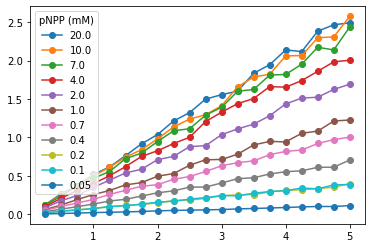

In [15]:
# Inspect the data using the plot command that is available with the dataframe
AP_kinetics_df_transpose.plot(marker = 'o')

There is some scatter in the data, but generally, the slopes of the curves increase with increasing substrate concentration.

Now we want to calculate the slope for each column. We can use the "apply" function to do this. Apply takes all of the row or column values and applies a function. There is a bit of a challenge here. We want to use the `linregress` function from scipy.stats to get the slopes. We used this function in the linear regression module and it returned five values: slope, intercept, r-value, p-value, and standard error for the best-fit line. So we need to define a new function that returns only the slope from `stats.linregress`. Here is the typical syntax for a function:

```python
# function definition
def function_name(parameters to be passed to the function):
    python code to be executed (must be indented following the colon)
    return function_output
```
Here is the syntax to call the function. It is just like the syntax we use to call a function from a library. 

```python
# function call
function_name(parameters to be passed to the function)
```

We will use this approach to define a function which returns only the slope. It will take in a pandas series, which always includes an index and a column. We have set the index (times) to be the x-values for the linear regression fit, so we just need to give a series that represents the y-values to this function.


In [16]:
def linregress_slope(df_series):

  # often times in python if you do not plan to use a variable, 
  # you can just name it with an underscore. This tells anyone 
  # reading your code and python that you don't intend to do 
  # anything with the values in the variable. Since we only want
  # the slope, we'll just name the rest of the variables with underscores.
  slope, _, _, _, _, = stats.linregress(df_series.index, df_series.values)
  return slope

In [17]:
# Create an empty dataframe
MM_df = pd.DataFrame() 
# Note the syntax for this pandas function - the D and F are capitalized.

In the next cell, we will use the `apply` function to the pandas dataframe. Remember that the AP_kinetics_df_transpose dataframe contains the time values as the indexes. Each of the columns contains the $\Delta$A$_{405}$ as a function of that time index. When we use `apply`, it applies the function `linregress_slope` to each column in the dataframe, using values in each column as the y-values and the dataframe index as the x-values. The values that it assigns to the new dataframe (MM_df in this case) has the column labels as the index ('pNPP (mM)') in this case, and the calculated slopes as the values in each row of the second column. ***This is my guess about what is happening here. It's only a guess.***

In [18]:
# Calculate the slopes and save them to the new dataframe
MM_df['slopes'] = AP_kinetics_df_transpose.apply(linregress_slope)

In [19]:
MM_df # Why does the first column contain the values for 'pNPP (mM)'? 
# The first column in AP_kinetics_df_transpose contains the time values.

,slopes
pNPP (mM),
20.00,0.514091
10.00,0.503140
7.00,0.470435
4.00,0.417021
2.00,0.342445
1.00,0.246260
0.70,0.202843
0.40,0.136443
0.20,0.076442


In [20]:
# Calculate initial velocities and place those in a new column in the dataframe
MM_df['initial velocities'] = MM_df['slopes'] / 0.015
MM_df

,slopes,initial velocities
pNPP (mM),,
20.00,0.514091,34.272718
10.00,0.503140,33.542678
7.00,0.470435,31.362310
4.00,0.417021,27.801416
2.00,0.342445,22.829652
1.00,0.246260,16.417302
0.70,0.202843,13.522863
0.40,0.136443,9.096204
0.20,0.076442,5.096143


We will use this dataframe now to perform the nonlinear regression fit using the SciPy library in part 2 of this lesson. To save this data for part 2, so we need to write it to a csv file in our data directory.

In [21]:
MM_df.to_csv('biochemist-python/chapters/data/MM_data.csv')

<div class="exercise-this-is-a-title exercise">
<p class="exercise-title">Check your understanding</p>
    <p>You will find an Excel file in your data folder, chymotrypsin_kinetics.xlsx, with some kinetic data from a chymotrypsin experiment. Apply the principles above to create dataframes and a .csv file for creating a Michaelis-Menten plot with these data. Under these assay conditions the extinction coefficient for p-nitrophenol is 18,320 M<sup>-1</sup>cm<sup>-1</sup>.</p>

```{admonition} Hint
:class: dropdown
    You will need to get the data into a layout and file format that is easily read by pandas. 
    <ul>
        <li>Delete the first seven lines of the Excel file.</li>
        <li>Delete the first column of the Excel file.</li>
        <li>Save the file as chymotrypsin_kinetics.csv.</li>
        <li>Your data will should look something like this:</li>
        <img src="biochemist-python/chapters/images/csv_image.png" alt="csv image">
    
```{admonition} Solution
:class: dropdown
    
```python
        import os 
        import pandas as pd 
        import numpy as np 
        from scipy import stats 
        datafile = os.path.join('biochemist-python', 'chapters', 'data', 'chymotrypsin_kinetics.csv') # filehandle created
        chymo_rates_df = pd.read_csv(datafile)
        chymo_rates_df = chymo_rates_df.set_index('Time (sec)')
        
        def linregress_slope(df_series):
            slope, _, _, _, _, = stats.linregress(df_series.index, df_series.values)
            return slope

        chymo_MM_df = pd.DataFrame()
        chymo_MM_df['slopes'] = chymo_rates_df.apply(linregress_slope)
        chymo_MM_df['Initial Velocities'] = chymo_MM_df['slopes'] / 0.01832
        chymo_MM_df.to_csv('biochemist-python/chapters/data/chymo_MM_data.csv')
        print(chymo_MM_df)
    
```
The solution is in the next cell. We will remove that cell before we publish the final Jupyter book.
        
</div>


In [22]:
import os 
import pandas as pd 
import numpy as np 
from scipy import stats 
datafile = os.path.join('biochemist-python', 'chapters', 'data', 'chymotrypsin_kinetics.csv') # filehandle created
chymo_rates_df = pd.read_csv(datafile)
chymo_rates_df = chymo_rates_df.set_index('Time (sec)')

def linregress_slope(df_series):
  slope, _, _, _, _, = stats.linregress(df_series.index, df_series.values)
  return slope

chymo_MM_df = pd.DataFrame()
chymo_MM_df['slopes'] = chymo_rates_df.apply(linregress_slope)
chymo_MM_df['Initial Velocities'] = chymo_MM_df['slopes'] / 0.01832 
chymo_MM_df.to_csv('biochemist-python/chapters/data/chymo_MM_data.csv')
print(chymo_MM_df)

              slopes  Initial Velocities
1           0.000557            0.030412
0.5         0.000539            0.029437
0.25        0.000500            0.027293
0.125       0.000450            0.024563
0.0625      0.000511            0.027877
0.03125     0.000493            0.026903
0.015625    0.000357            0.019495
0.0078125   0.000229            0.012477
0.00390625  0.000111            0.006043
0.00195313  0.000071            0.003899
